In [3]:
import pandas as pd 
import numpy as np 

import missingno as msn
from sklearn import metrics, neighbors, model_selection, preprocessing, pipeline, compose
from matplotlib import pyplot as plt 
import warnings

warnings.filterwarnings("ignore")

Problem 1

1. What to learn and predict?

I am expected to learn user transaction information, telco information and other relevant information and use this to predict a users repayment ability.

2. What kind of file to create and submit to kaggle?

 The kind od file to create on Kaggle is a csv file containing the user ID and probability of repayment.

3. What kind of index value will be used to evaluate submission?

The kind of index value to be submitted is
Area under the ROC curve.


Base model

In [21]:
#Obtaining  data

import pandas as pd
    
path = 'application_train.csv'

# Read the CSV file using Pandas
data = pd.read_csv(path)

# Display the first few rows of the dataframe to verify it was read correctly
data.head()

path = data.dropna(axis=0, how="any")

In [16]:
features = ['NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY']
target = ['TARGET']
path.drop([x for x in path.keys() if x not in features + target] , inplace=True, axis=1)

In [20]:
categorical = ["NAME_CONTRACT_TYPE", "CODE_GENDER", "FLAG_OWN_CAR", "FLAG_OWN_REALTY"]
lb = preprocessing.LabelEncoder()
for category in categorical:
   path[category] = lb.fit_transform(path[category])

Base ROC scrore: 0.5
Base ROC scrore: 0.5


Text(0, 0.5, 'Prediction')

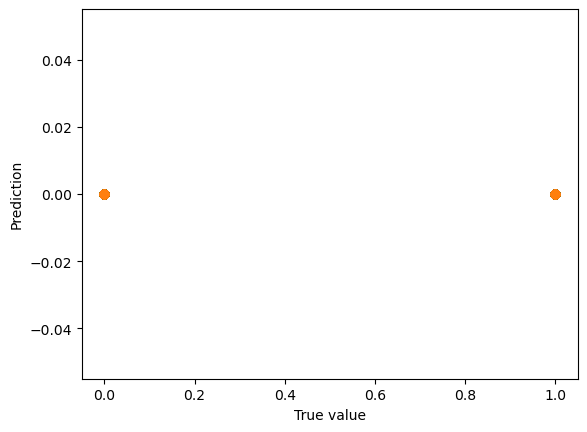

In [19]:
#train test split and model training 


x_train, x_test, y_train, y_test = model_selection.train_test_split(path[features],path[target], test_size=0.2, random_state=0)

y_train, y_test = np.ravel(y_train), np.ravel(y_test)

base_model = neighbors.KNeighborsClassifier(int(np.sqrt(len(x_train)))).fit(x_train, y_train)

base_prediction = base_model.predict(x_test)

base_score = metrics.roc_auc_score(y_test, base_prediction)

print(f"Base ROC scrore: {base_score}")

plt.scatter(y_test, base_prediction)
plt.xlabel("True value")
plt.ylabel("Prediction")
x_train, x_test, y_train, y_test = model_selection.train_test_split(path[features], path[target], test_size=0.2, random_state=0)

y_train, y_test = np.ravel(y_train), np.ravel(y_test)

base_model = neighbors.KNeighborsClassifier(int(np.sqrt(len(x_train)))).fit(x_train, y_train)

base_prediction = base_model.predict(x_test)

base_score = metrics.roc_auc_score(y_test, base_prediction)

print(f"Base ROC scrore: {base_score}")

plt.scatter(y_test, base_prediction)
plt.xlabel("True value")
plt.ylabel("Prediction")

As indicated by the ROC score, the base model only correctly half of the time.

Problem 2(Learning and verification)

In [22]:
# Preprocessing, standardization and label encoding

def preprocessor(data):
    """
    Standardizes numerical data and encodes categorical data
    """

    #scaler and encoder
    scaler = preprocessing.StandardScaler()
    encoder = preprocessing.LabelEncoder()
    data = data.copy()

    for label in data.keys():
        dtype = data[label].dtype
        
        if dtype == "O":
           data[label] = encoder.fit_transform(data[label])
        """else:
            val = data[label].values
            data[label] =scaler.fit_transform([val]).reshape((-1, 1))
        """

    return data

In [23]:
credit_info = data.copy()

credit_info.drop(["SK_ID_CURR", "TARGET"], axis=1, inplace=True)
credit_info = pd.concat((preprocessor(credit_info), data["TARGET"]), axis=1)

credit_info.info(verbose=4)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 121 columns):
 #    Column                        Dtype  
---   ------                        -----  
 0    NAME_CONTRACT_TYPE            int32  
 1    CODE_GENDER                   int32  
 2    FLAG_OWN_CAR                  int32  
 3    FLAG_OWN_REALTY               int32  
 4    CNT_CHILDREN                  int64  
 5    AMT_INCOME_TOTAL              float64
 6    AMT_CREDIT                    float64
 7    AMT_ANNUITY                   float64
 8    AMT_GOODS_PRICE               float64
 9    NAME_TYPE_SUITE               int32  
 10   NAME_INCOME_TYPE              int32  
 11   NAME_EDUCATION_TYPE           int32  
 12   NAME_FAMILY_STATUS            int32  
 13   NAME_HOUSING_TYPE             int32  
 14   REGION_POPULATION_RELATIVE    float64
 15   DAYS_BIRTH                    int64  
 16   DAYS_EMPLOYED                 int64  
 17   DAYS_REGISTRATION             float64
 18   DA

In [24]:
# select features with over 70% null values
thresh = 0.7

empty_features = credit_info.keys()[((credit_info.isna().sum() / len(credit_info) ) >= thresh).values]

#dropping unwanted features
credit_info.drop(empty_features, axis=1, inplace=True)

<Axes: >

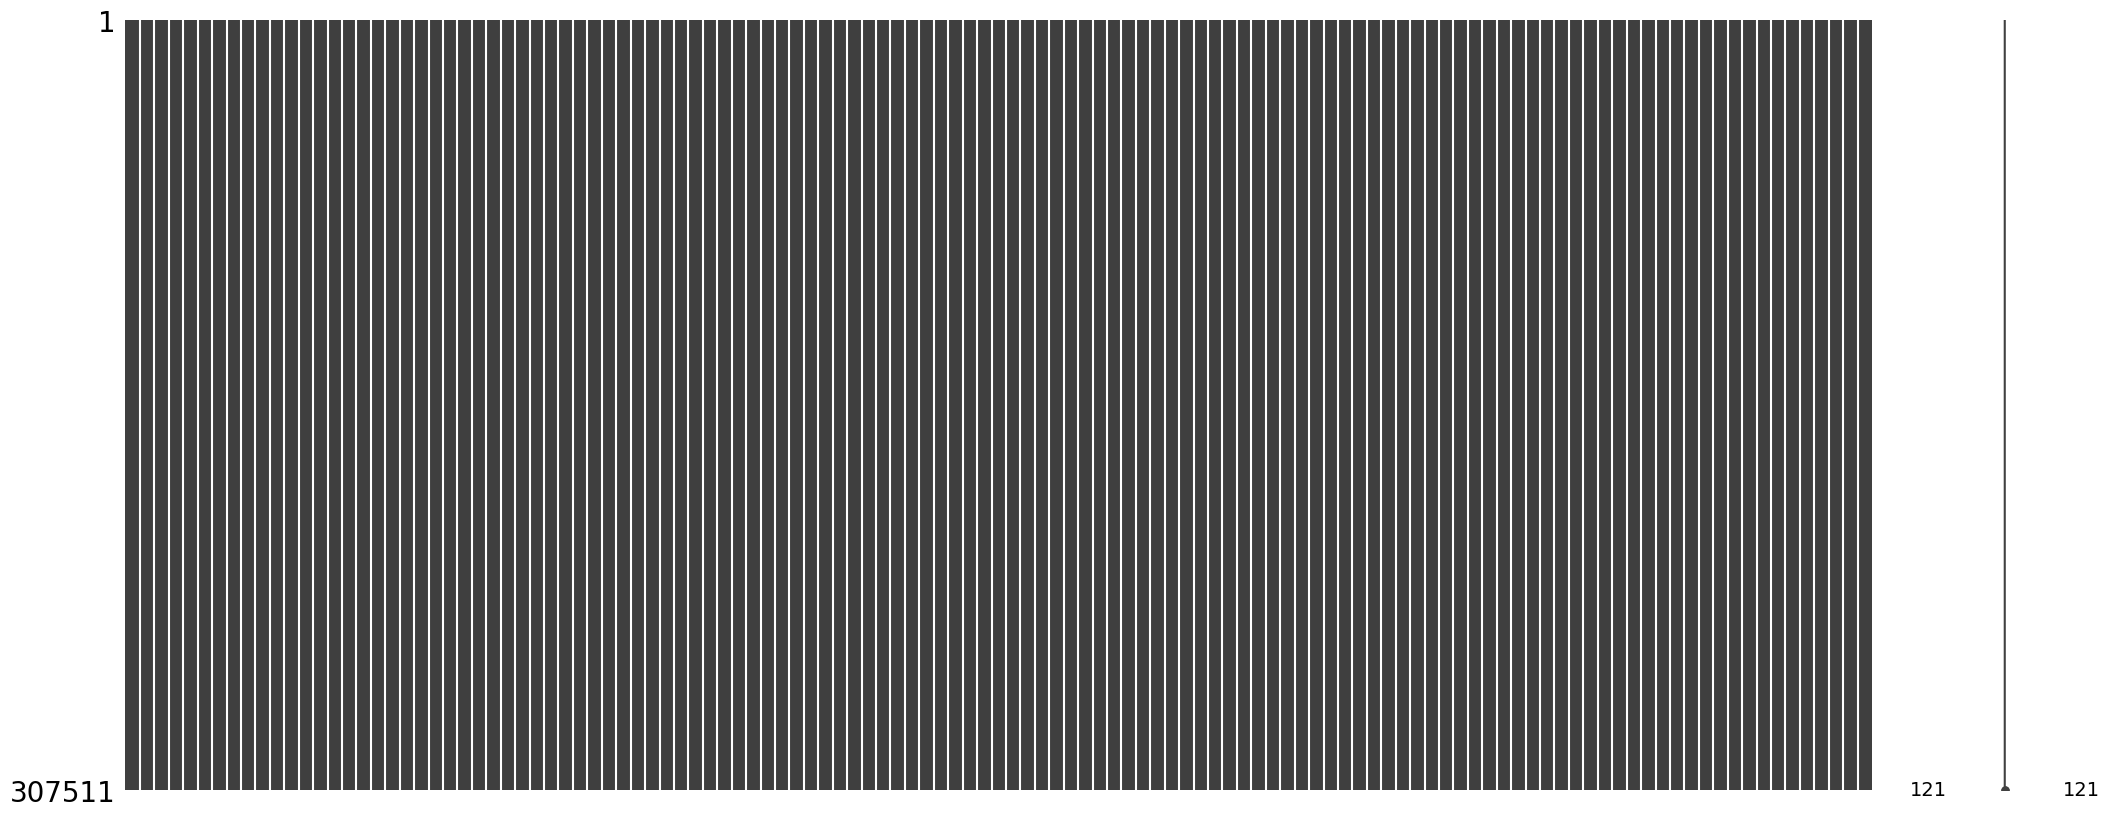

In [25]:
thresh = 0

null_features = credit_info.keys()[((credit_info.isna().sum() / len(credit_info) ) > thresh).values]

for feat in null_features:
    credit_info[feat].fillna(credit_info[feat].mean(), inplace =True)

msn.matrix(credit_info)

In [26]:
#FEATURES THAT CORRELATE WITH TARGET VARIABLE
mat= credit_info.corr(numeric_only=True)

# extracting features with the best correlation with target variable
thresh = 0.05

potential_feat = (mat[(np.abs(mat) > thresh) & (np.abs(mat) < 1)]["TARGET"]).keys()

condition = (np.abs(mat["TARGET"]) > thresh) & ( np.abs(mat["TARGET"] )< 1)

interest_feat = potential_feat[condition]

In [27]:
#train test split and model training 


target = credit_info["TARGET"]

credit_info.drop([x for x in credit_info.keys() if x not in interest_feat], axis=1, inplace=True)

x_train, x_test, y_train, y_test = model_selection.train_test_split(credit_info, target, test_size=0.2, random_state=0)

In [28]:
model = neighbors.KNeighborsClassifier(algorithm="kd_tree", n_neighbors=11, p=1, weights="distance").fit(x_train, y_train)

prediction = model.predict(x_test)

In [29]:
roc = metrics.roc_auc_score(y_test, prediction)

print(f"ROC_AUC score: {roc}")

ROC_AUC score: 0.5019450921810895


In [30]:
print(metrics.classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56648
           1       0.20      0.01      0.01      4855

    accuracy                           0.92     61503
   macro avg       0.56      0.50      0.48     61503
weighted avg       0.86      0.92      0.88     61503



In [31]:
metrics.confusion_matrix(y_test, prediction)

array([[56530,   118],
       [ 4826,    29]], dtype=int64)

Problem 3(Estimation on test data)

In [37]:
test_data = pd.read_csv("C:\\Users\\cbt04\\Downloads\\application_train.csv.zip")

test_data["SK_ID_CURR"]

test_data = preprocessor(test_data)


test_data.dropna(axis=0, how="any", inplace=True)
id = test_data["SK_ID_CURR"]

test_data.drop([x for x in test_data.keys() if x not in interest_feat], axis=1, inplace=True)

In [38]:
predict = model.predict_proba(test_data)

x = np.vstack((id, predict[:, 0])).T

result = pd.DataFrame(x, columns=["ID", "Prob"])

In [39]:
result.to_csv("C:\\Users\\cbt04\\Downloads\\application_train.csv.zip")

Problem 4 (Feature Engineering)

1. Which features to use?
To determine what features to use for this problem, I performed a correlation analysis to evaluate the strenght of association between the features and my target variable. The correlation analysis showed the the features are weakly associated with the target variable, nevertheless, I selected the best features.

2. How to preprocess?
Preprocessing involves the cleaning up data. It involves data cleaning, data transformation, data encoding, data transformation, etc. For this anaylsis, I cleaned up my data by removing null dropping null data points. I encoded catergorical variables, and split the data into a train and test set.
After my analsis and training of both a base model and real model, I found that my real model did not perform significantly better than the base model. There was a slight improvement of 0.002 in the ROC_AUC score. This is greatly influence by the featueres I selected.